<a href="https://colab.research.google.com/github/swapnilsethi/Stat-5000/blob/main/Model_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XGBoost (eXtreme Gradient Boosting)**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import math
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
pd.pandas.set_option('display.max_columns',None)  #To display all columns 

**Import data**

In [ ]:
URL = ("https://raw.githubusercontent.com/swapnilsethi/Stat-5000/master/X_train.csv")
data = pd.read_csv(URL)
#print(data)
Feature_kept_for_replacement_detection = [feature for feature in data if '_nan' in feature]
#print(Feature_kept_for_replacement_detection)
data = data.drop(Feature_kept_for_replacement_detection,1)
X = data.drop(['Unnamed: 0', 'Id','SalePrice','Unnamed: 0'],1)
Y = (data['SalePrice']).to_frame()
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
Y = Y.to_numpy()
y_train= y_train.to_numpy()
y_test = y_test.to_numpy()

**Model Design**

In [ ]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42, learning_rate=0.111)

In [ ]:
xg_reg.fit(X_train,y_train)

XGBRegressor(learning_rate=0.111, objective='reg:squarederror', random_state=42)

In [ ]:
preds = xg_reg.predict(X_test)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mse = sklearn.metrics.mean_squared_error(np.log(test_labels),np.log(predictions))
    RMSE = math.sqrt(mse)
    print('Model Performance')
    print('RMSE: {:0.4f} degrees.'.format(RMSE))
    return RMSE
XGB_accuracy = evaluate(xg_reg, X_test, y_test)

Model Performance
RMSE: 0.1338 degrees.


Without any hyperparamter tuning, I got RMSE of 0.1338. Which is better than the RF model.

# **Making Predications on actual Test data**

In [ ]:
# Reading test data
URL = "https://raw.githubusercontent.com/swapnilsethi/Stat-5000/master/X_test.csv"

# Removing unwanted columns
test_data = pd.read_csv(URL)
Feature_kept_for_replacement_detection = [feature for feature in test_data if '_nan' in feature]
#print(Feature_kept_for_replacement_detection)
test_data = test_data.drop(Feature_kept_for_replacement_detection,1)
ID = test_data.iloc[:, 1].values 
test_data= test_data.drop(['Unnamed: 0', 'Id'],1)

# Making Predications

Y_pred = xg_reg.predict(test_data)

Now that I've created predictions with our model, but since this is a Kaggle competition problem, I can submit the prediction file and have it checked for correctness.

**Predication File Generator**

In [ ]:
def Predications_file_generator(predications): 
    pred = pd.DataFrame(ID, columns=['Id'])
    pred['SalePrice'] = predications.tolist()

    pred.to_csv('pred.csv')
    files.download('pred.csv')

In [ ]:
Predications_file_generator(Y_pred)


On actual data I got RMSE Of 0.13387. Which is far better than what I was able to achieve by Random Forest Model




Prediction Error Plot


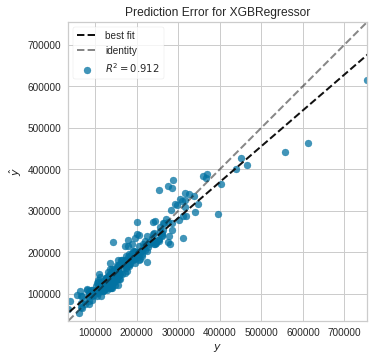

PredictionError(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f6784aa90>,
                estimator=XGBRegressor(learning_rate=0.111,
                                       objective='reg:squarederror',
                                       random_state=42))


In [ ]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(xg_reg, X_train, y_train, X_test, y_test))

See that most of the points are on a straight line. Compare this plot against the 45-degree line, where the prediction exactly matches the model. In general, the predictions follow the actual house prices.

# **Hyperparameter Tuning**

In [ ]:
from pprint import pprint
# Look at parameters used by our base model
print('Parameters currently in use:\n')
pprint(xg_reg.get_params())

Parameters currently in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.111,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


**Design Hyperparamter Grid**

In [ ]:
#Random Hyperparameter Grid 
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 5)]
max_depth.append(1)

# Learning Rate
learning_rate = [0.07, 0.09, 0.1, 0.11,0.111, 0.12]

# Fraction of columns to be randomly sampled for each tree
colsample_bytree = [0.3, 0.4, 0.5, 0.6, 0.8]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate,
               'colsample_bytree': colsample_bytree
               }
pprint(random_grid)

{'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.8],
 'learning_rate': [0.07, 0.09, 0.1, 0.11, 0.111, 0.12],
 'max_depth': [1, 25, 50, 75, 100, 1],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


**Random Search**

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
XGB_regressor = xgb.XGBRegressor(objective ='reg:squarederror')
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
# n_jobs =  Number of jobs to run in parallel; verbose = Controls the verbosity when fitting and predicting.
XGB_random = RandomizedSearchCV(estimator = XGB_regressor, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = 10)
# Fit the random search model
XGB_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=XGBRegressor(objective='reg:squarederror'),
                   n_iter=100, n_jobs=10,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.8],
                                        'learning_rate': [0.07, 0.09, 0.1, 0.11,
                                                          0.111, 0.12],
                                        'max_depth': [1, 25, 50, 75, 100, 1],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42)

In [ ]:
XGB_random.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.07,
 'max_depth': 50,
 'n_estimators': 400}

Now, I am training my model with above parameters

In [ ]:
xgb_tuned_regressor = xgb.XGBRegressor(objective ='reg:squarederror',
 max_depth= 100,
 colsample_bytree= 0.38,
 learning_rate= 0.071,
 n_estimators= 100)
xgb_tuned_regressor.fit(X_train, y_train)

XGBRegressor(colsample_bytree=0.38, learning_rate=0.071, max_depth=100,
             objective='reg:squarederror')

In [ ]:
Hyperparameter_model = evaluate(xgb_tuned_regressor, X_test, y_test)

Model Performance
RMSE: 0.1384 degrees.


With Hyperparamter tuning RMSE is not decreasing, which I think because of dataset size. I've to think something else to reduce RMSE further than tuning.

In [ ]:
Y_pred = xgb_tuned_regressor.predict(test_data)

In [ ]:
Predications_file_generator(Y_pred)

**k-fold Cross Validation using XGBoost**


In [ ]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.01,  
                'n_estimators': 1000, 'max_depth': 100 }

In [ ]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [ ]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,195325.416667,1505.242196,195340.546875,3030.878887
1,193489.984375,1496.664255,193512.390625,3004.951337
2,191668.828125,1495.745693,191733.208333,2987.057342
3,189866.317708,1493.466754,189948.828125,2968.838987
4,188082.781250,1490.409658,188210.005208,2947.313428


In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))
print((cv_results["test-rmse-std"]).tail(1))


49    125186.786458
Name: test-rmse-mean, dtype: float64
49    3502.321145
Name: test-rmse-std, dtype: float64
